In [22]:
%%bigquery users_devices_20230327
SELECT event_date, user_pseudo_id, user_id, device.category as device_type,
    device.mobile_brand_name as device_brand,
    device.mobile_model_name as device_model,
    device.mobile_marketing_name as device_name,
    device.operating_system as device_os,
    device.operating_system_version as device_os_version,
    h.key as key,
    h.value.string_value as client_id,
FROM `vertex-ai-sandbox-380023.analytics_250000498.events_20230327` 
left join unnest(user_properties) as h
where key = "client_id"
# where user_properties.key = "client_id"

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
has_uid = users_devices_20230327[~users_devices_20230327["user_id"].isna()]

In [25]:
# ratio_no_clientid
users_devices_20230327[users_devices_20230327["client_id"].isna()].shape[0]\
    /users_devices_20230327.shape[0]

0.20051023445703986

In [ ]:
has_uid_no_pseudo = users_devices_20230327[(~users_devices_20230327["user_id"].isna()) & (users_devices_20230327["user_pseudo_id"].isna())]
has_uid_no_pseudo

In [23]:
has_uid_no_pseudo_hits = has_uid_no_pseudo.groupby(["user_id"])\
    .device_type.count()\
    .reset_index()\
    .rename(columns={"device_type": "hits"})

In [27]:
has_uid_no_pseudo_hits.shape[0]/users_devices_20230327.groupby(["user_pseudo_id"]).device_type.count().shape[0] *100

0.04125231939061064

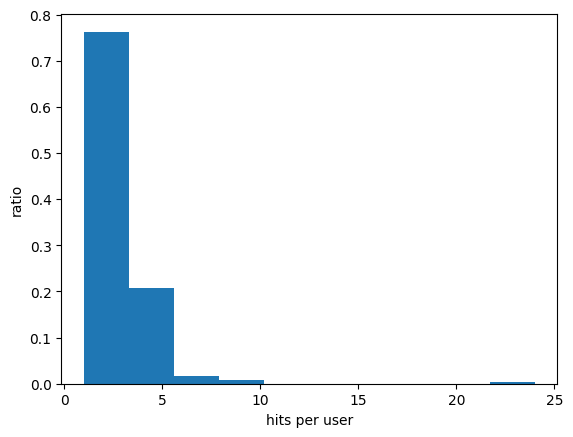

In [28]:
plt.hist(has_uid_no_pseudo_hits.hits, weights=np.ones(has_uid_no_pseudo_hits.hits.shape[0])/has_uid_no_pseudo_hits.hits.shape[0])
plt.xlabel("hits per user")
plt.ylabel("ratio")
plt.show()

In [14]:
print(has_uid.shape)
users = has_uid.groupby(["user_id"]).user_pseudo_id.count().reset_index()

(77674, 9)


In [13]:
users.shape[0]/users_devices_20230327.groupby(["user_pseudo_id"]).device_type.count().shape[0] *100

1.358464134054884

In [17]:
users[users["user_id"] != "."].describe()

,user_pseudo_id
count,8068.000000
mean,9.522682
std,195.731202
min,0.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,17577.000000


In [52]:
unique_types = users_devices_20230327[["user_pseudo_id", "device_type"]].drop_duplicates()
unique_types.shape

(594450, 2)

In [ ]:
unique_types.groupby(["user_pseudo_id"]).device_type.count().reset_index().sort_values(by="device_type", ascending=False)

In [ ]:
users_devices_20230327[users_devices_20230327["user_pseudo_id"] == "1504432482.1679738554"]

In [ ]:
users_devices_20230327[users_devices_20230327["user_pseudo_id"] == "2121784584.1679884593"]


In [4]:
users_devices_20230327.shape

(4012928, 8)

In [29]:
users_devices_20230327.columns

Index(['event_date', 'user_pseudo_id', 'user_id', 'device_type',
       'device_brand', 'device_model', 'device_name', 'device_os',
       'device_os_version'],
      dtype='object')

In [48]:
devices_types_info_pseudo = users_devices_20230327\
    [~users_devices_20230327["user_pseudo_id"].isna()]\
    .groupby(["event_date", 'device_type', 'device_brand', 'device_model',\
              'device_name', 'device_os', 'device_os_version'])\
    .agg({"user_pseudo_id": [pd.Series.nunique, pd.Series.count]})\
    .reset_index()
devices_types_info_pseudo.head(3)

event_date device_type device_brand device_model       device_name  \
                                                                       
0   20230327     desktop         AT&T       U102AA  Cingular Flip IV   
1   20230327      mobile         AT&T     EA211002        Motivate 2   
2   20230327      mobile         AT&T       U202AA           Maestro   

  device_os device_os_version user_pseudo_id        
                                     nunique count  
0      OS/2             OS/2               1     5  
1   Android    Android 11.0.0              1     4  
2   Android     Android 9.0.0              1     5

In [49]:
new_cols_list = list(devices_types_info_pseudo.columns.get_level_values(0)[:-2])\
    + list(devices_types_info_pseudo.columns.get_level_values(1)[-2:-1])
new_cols_list.append("hits")
devices_types_info_pseudo.columns = new_cols_list

In [81]:
# hits per user

puid_types_info = users_devices_20230327\
    [~users_devices_20230327["user_pseudo_id"].isna()]\
    .groupby(["user_pseudo_id", "device"])\
    .agg({"event_date": pd.Series.count})\
    .reset_index()\
    .rename(columns={"event_date": "hits"})

In [45]:
devices_types_info.columns

MultiIndex([(    'event_date',        ''),
            (        'device',        ''),
            ('user_pseudo_id', 'nunique'),
            ('user_pseudo_id',   'count')],
           )

In [48]:
devices_types_info_lvl = devices_types_info.copy()

In [47]:
# devices_types_info_lvl.columns = devices_types_info_lvl.columns.get_level_values(1)

In [49]:
list(devices_types_info_lvl.columns.get_level_values(0)[:2]) + list(devices_types_info_lvl.columns.get_level_values(1)[2:])

['event_date', 'device', 'nunique', 'count']

In [50]:
devices_types_info_lvl.columns = \
    (list(devices_types_info_lvl.columns.get_level_values(0)[:2])\
    + list(devices_types_info_lvl.columns.get_level_values(1)[2:]))

devices_types_info_lvl

,event_date,device,nunique,count
0,20230327,desktop,336069,1551270
1,20230327,mobile,246490,2292501
2,20230327,smart tv,38,249
3,20230327,tablet,11849,118741


In [51]:
devices_types_info_lvl["hits_per_puid"] = round(\
                                                devices_types_info_lvl["count"]/devices_types_info_lvl["nunique"],\
                                                2)

In [54]:
list_of_devices = list(devices_types_info_lvl.device.unique())

In [ ]:
df_list = list()
df_list.append(devices_types_info)
df_list.append(devices_types_info_lvl)
df_list

In [84]:
df_list = list()
name_list = list()
for device in list_of_devices:
    print(puid_types_info.shape)
    device_filtered = puid_types_info[puid_types_info["device"] == device]
    print(device_filtered.shape)
    name_list.append(device)
    df_list.append(device_filtered)

(594446, 3)
(336069, 3)
(594446, 3)
(246490, 3)
(594446, 3)
(38, 3)
(594446, 3)
(11849, 3)


In [69]:
df_list

[  event_date   device  nunique    count  hits_per_puid
 0   20230327  desktop   336069  1551270           4.62,
   event_date  device  nunique    count  hits_per_puid
 1   20230327  mobile   246490  2292501            9.3,
   event_date    device  nunique  count  hits_per_puid
 2   20230327  smart tv       38    249           6.55,
   event_date  device  nunique   count  hits_per_puid
 3   20230327  tablet    11849  118741          10.02]

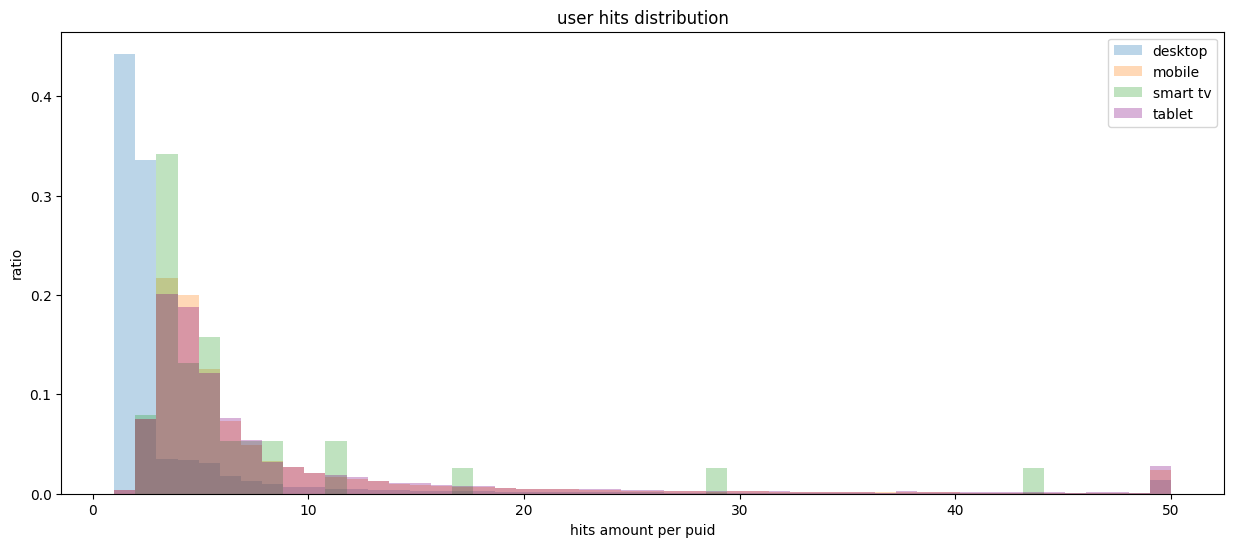

In [96]:
upper_l = 50

plt.figure(figsize=(15,6))
_, bins, _ = plt.hist(df_list[0]["hits"].clip(upper=upper_l), bins=50, label=name_list[0], alpha=0.3, weights=np.ones(df_list[0].shape[0])/df_list[0].shape[0])
plt.hist(df_list[1]["hits"].clip(upper=upper_l), bins=bins, label=name_list[1], alpha=0.3, weights=np.ones(df_list[1].shape[0])/df_list[1].shape[0])
plt.hist(df_list[2]["hits"].clip(upper=upper_l), bins=bins, label=name_list[2], alpha=0.3, weights=np.ones(df_list[2].shape[0])/df_list[2].shape[0])
plt.hist(df_list[3]["hits"].clip(upper=upper_l), bins=bins, label=name_list[3], color="purple", alpha=0.3, weights=np.ones(df_list[3].shape[0])/df_list[3].shape[0])

plt.xlabel("hits amount per puid")
plt.ylabel("ratio")
plt.title("user hits distribution")
plt.legend()
plt.show()